In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import harmony as harm
from astropy.io import fits
from tqdm import tqdm
import camb

import glass.shells
import glass.lensing

from mass_maping import kaiser_squire

In [2]:
num_sim = 1
path_output = f'/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim{num_sim:05d}.npy'
output = np.load(path_output, allow_pickle=True).item()

This notebook is meant to check that the output of the UNIONS forward model pipeline is correct.

In [3]:
output.keys()

dict_keys(['cosmo_params', '/kappa_lensing', 'kappa_ia', 'gamma_lensing', 'z_bin_edges', 'gamma_weighted', 'sys_map', 'masked_shear_map', 'noise_map', 'nuisance_parameters', 'config'])

In [4]:
#Check the config
output['config']

{'simulation': {'path_simulation': '/n17data/sguerrini/GowerStreetSims/',
  'path_info': '/n17data/sguerrini/GowerStreetSims/PKDGRAV3_on_DiRAC_DES_330 - Sheet1.csv',
  'path_output': '/n17data/sguerrini/GowerStreetSims/processed/',
  'sim_number': 1,
  'sim_name': 'GowerStreet'},
 'preprocessing': {'nside': 512},
 'ray_tracing': {'method': 'glass', 'save_ray_tracing': 'F'},
 'intrinsic_alignment': {'add_ia': 'T', 'A_ia': 0.49, 'eta_ia': 0.0},
 'redshift_distribution': {'weight_w_redshift': 'T',
  'nbins': 1,
  'path_dndz': '/n17data/mkilbing/astro/data/CFIS/v1.0/nz/dndz_SP_A.txt',
  'save': 'T'},
 'shape_noise': {'add_shape_noise': 'T',
  'path_gal': '/n17data/mkilbing/astro/data/CFIS/v1.0/SP_LFmask/unions_shapepipe_2022_v1.3_mtheli8k.fits',
  'ra_col': 'RA',
  'dec_col': 'DEC',
  'e1_col': 'e1',
  'e2_col': 'e2',
  'w_col': 'w',
  'save': 'T'},
 'psf_systematic': {'add_systematic': 'T',
  'path_psf': '/n17data/mkilbing/astro/data/CFIS/v1.0/SP_LFmask/unions_shapepipe_star_2022_v1.3_mth

In [5]:
#Check cosmo_params and nuisance params
print(output['cosmo_params'])
print(output['nuisance_parameters'])

{'h': array([0.66736206]), 'Omega_m': array([0.29004048]), 'Omega_b': array([0.05021784]), 'sigma_8': array([0.7657514]), 'n_s': array([0.94965154]), 'w': array([-1.00894147]), 'm_nu': array([0.06]), 'A_s': array([2.22033589e-09])}
{'A_ia': 0.49, 'eta_ia': 0.0, 'alpha': 0.003213549711272551, 'beta': 0.9019839255978924, 'eta': -3.447551595519223}


In [6]:
output['/kappa_lensing'].shape[0] == output['z_bin_edges'].shape[0] - 1

True

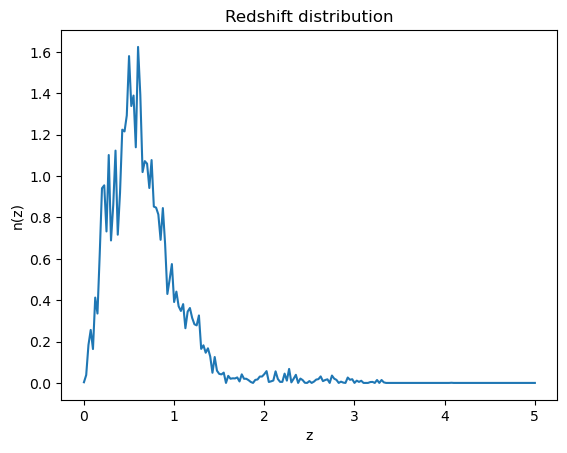

In [7]:
redshift_distr = np.loadtxt(output['config']['redshift_distribution']['path_dndz'])
dndz, z = redshift_distr[:, 1], redshift_distr[:, 0]

plt.figure()

plt.plot(z, dndz)
plt.title('Redshift distribution')
plt.xlabel('z')
plt.ylabel('n(z)')

plt.show()

In [8]:
nside = output['config']['preprocessing']['nside']

gamma_avg_1 = np.zeros(hp.nside2npix(nside))
gamma_avg_2 = np.zeros(hp.nside2npix(nside))
kappa_avg = np.zeros(hp.nside2npix(nside))

weights = glass.shells.tophat_windows(output['z_bin_edges'])

for i in tqdm(range(output['/kappa_lensing'].shape[0])):
    z_i, dndz_i = glass.shells.restrict(z, dndz, weights[i])

    ngal = np.trapz(dndz_i, z_i)
    gamma_i = glass.lensing.from_convergence(output['/kappa_lensing'][i]+output['kappa_ia'][i], lmax=2*nside, shear=True)[0]
    gamma_avg_1 += gamma_i.real * ngal
    gamma_avg_2 += gamma_i.imag * ngal
    kappa_avg += (output['/kappa_lensing'][i]+output['kappa_ia'][i]) * ngal

gamma_avg_1 /= np.trapz(dndz, z)
gamma_avg_2 /= np.trapz(dndz, z)
kappa_avg /= np.trapz(dndz, z)

  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 77/77 [01:49<00:00,  1.42s/it]


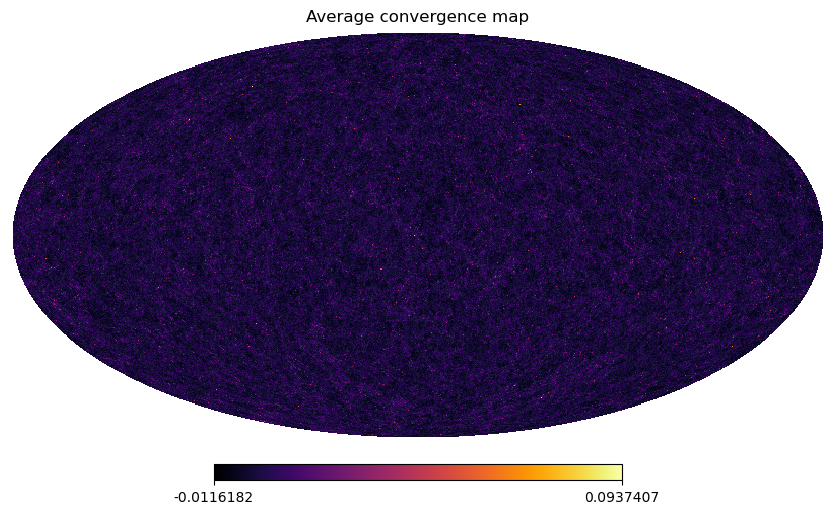

In [9]:
hp.mollview(kappa_avg, title='Average convergence map', cmap='inferno')
plt.show()

In [10]:
np.all(np.isclose(gamma_avg_1+1j*gamma_avg_2, output['gamma_weighted']))

True

In [11]:
gamma_avg_1+1j*gamma_avg_2

array([ 1.71923717e-03+0.00309418j, -2.17047814e-04-0.00325808j,
       -1.32028472e-03+0.00082j   , ..., -1.22071257e-03+0.0033187j ,
        4.74595053e-05-0.00120874j, -1.54170351e-03+0.00234892j])

In [12]:
output['gamma_weighted']

array([ 1.7192373e-03+0.00309418j, -2.1704781e-04-0.00325808j,
       -1.3202847e-03+0.00082j   , ..., -1.2207127e-03+0.0033187j ,
        4.7459525e-05-0.00120874j, -1.5417036e-03+0.00234892j],
      dtype=complex64)

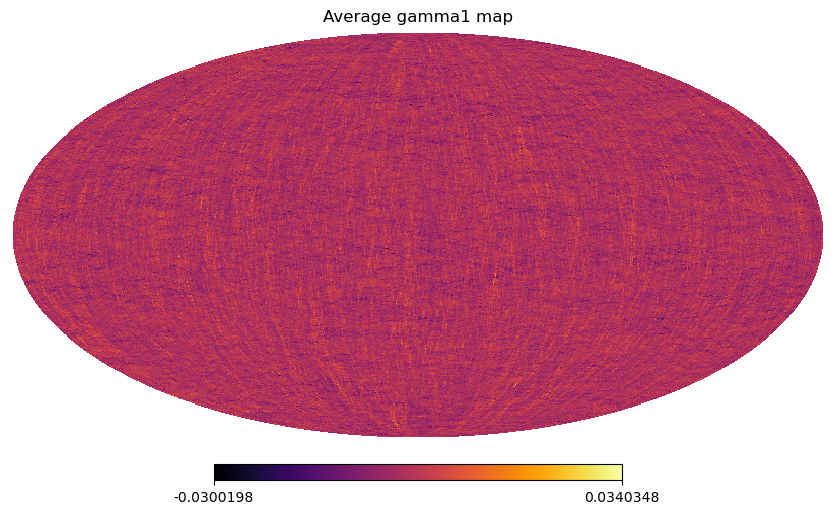

In [13]:
hp.mollview(gamma_avg_1, title='Average gamma1 map', cmap='inferno')
plt.show()

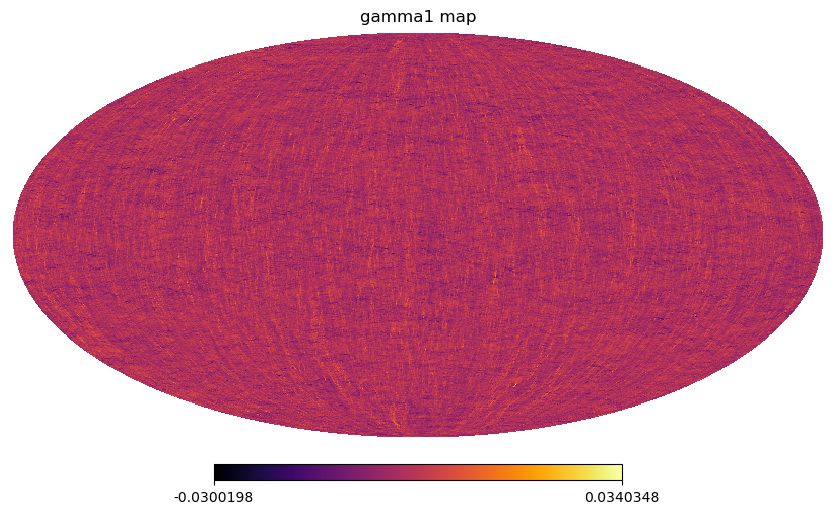

In [14]:
hp.mollview(output['gamma_weighted'].real, title='gamma1 map', cmap='inferno')
plt.show()

In [15]:
#Checking the power spectrum of the convergence and shear fields
#Load parameters for the cosmology
h = output['cosmo_params']["h"]
Om = output['cosmo_params']["Omega_m"]
Ob = output['cosmo_params']["Omega_b"]
Oc = Om - Ob
ns = output['cosmo_params']["n_s"]
m_nu = output['cosmo_params']["m_nu"]
w = output['cosmo_params']["w"]
As = output['cosmo_params']["A_s"]

nside=512
lmax = 2*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
Onu = pars.omeganu
Oc = Om - Ob - Onu
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the angular power spectra of the lensing map
sim_cls = hp.anafast([kappa_avg, output['gamma_weighted'].real, output['gamma_weighted'].imag], pol=True, lmax=lmax, use_pixel_weights=True)

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

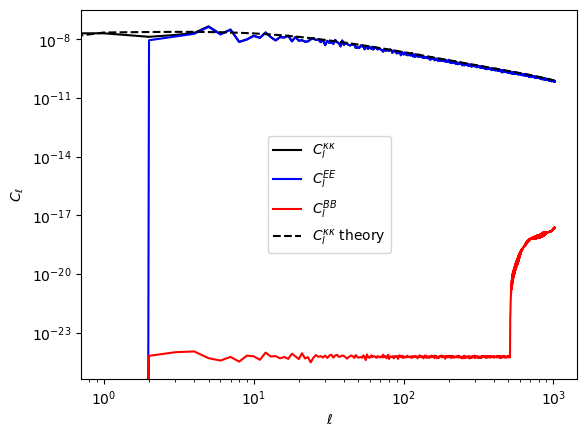

In [16]:
pw = hp.pixwin(nside, lmax=lmax)

plt.figure()

l = np.arange(lmax+1)
plt.plot(l, sim_cls[0], label='$C_l^{\kappa\kappa}$', c='k')
plt.plot(l, sim_cls[1], label='$C_l^{EE}$', c='b')
plt.plot(l, sim_cls[2], label='$C_l^{BB}$', c='r')
plt.plot(l, theory_cls['W1xW1']*pw**2, label='$C_l^{\kappa\kappa}$ theory', c='k', ls='--')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

In [17]:
#Look at the convergence reconstruction
kappa_reconstructed_E, kappa_reconstructed_B = kaiser_squire(output['gamma_weighted'])

/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: invalid value encountered in multiply
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: invalid value encountered in multiply


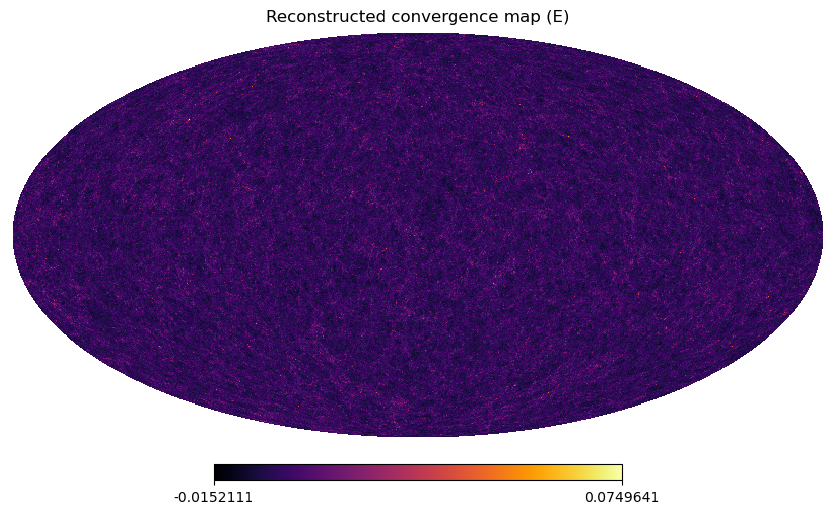

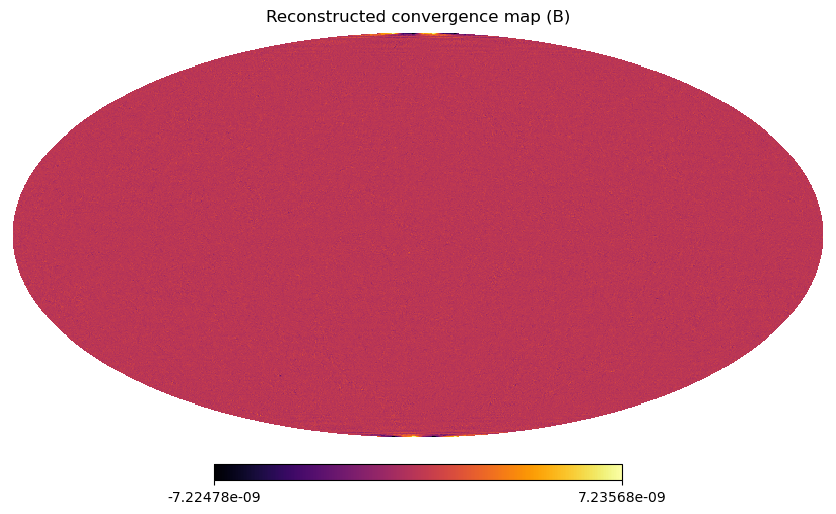

In [18]:
hp.mollview(kappa_reconstructed_E, title='Reconstructed convergence map (E)', cmap='inferno')
plt.show()

hp.mollview(kappa_reconstructed_B, title='Reconstructed convergence map (B)', cmap='inferno')
plt.show()

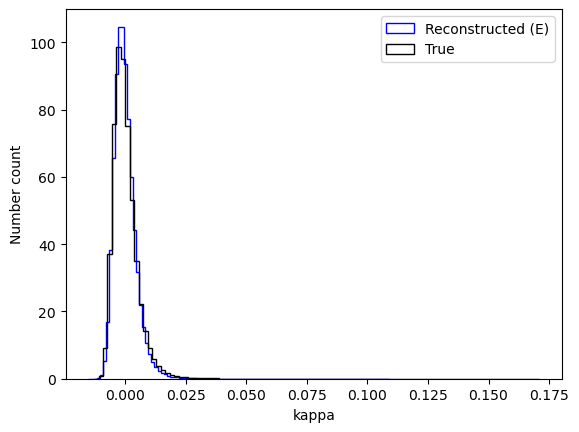

In [19]:
#Compare the pdf (theory with Vilasini emulator?)
plt.figure()

plt.hist(kappa_reconstructed_E, bins=100, histtype='step', label='Reconstructed (E)', color='b', density=True)
#plt.hist(kappa_reconstructed_B, bins=100, histtype='step', label='Reconstructed (B)', color='r', density=True)
plt.hist(kappa_avg, bins=100, histtype='step', label='True', color='k', density=True)

plt.xlabel('kappa')
plt.ylabel('Number count')

plt.legend()

plt.show()

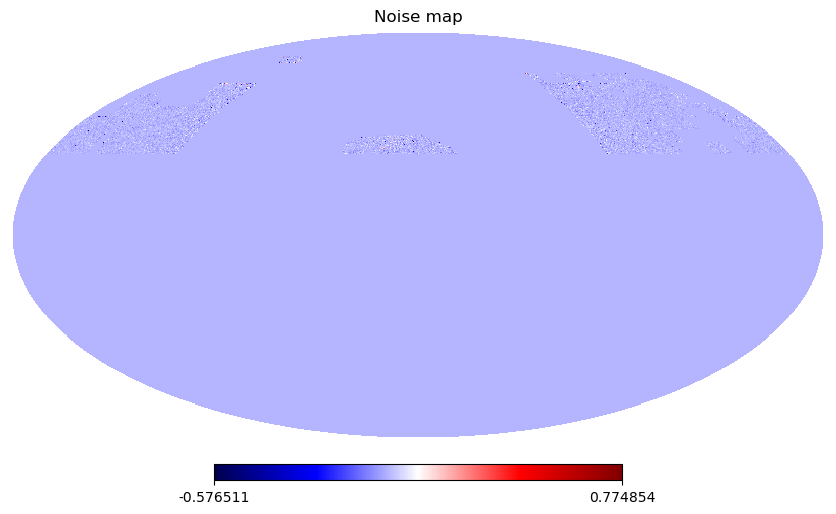

In [20]:
#Look at the noise map + mask
hp.mollview(output['noise_map'].real, title='Noise map', cmap='seismic')
plt.show()

In [30]:
#Measure the pseudo-Cl's of the noise map (should correspond to the noise bias in Doux et al.)
lmin = 8
lmax = 3*nside-1
b_lmax = 3*nside-1
n_ell_bins = 28

b = nmt.NmtBin.from_nside_linear(nside, 10)

ell_eff = b.get_effective_ells()

f_noise = nmt.NmtField(mask=(output['noise_map'] != 0), maps=[output['noise_map'].real, output['noise_map'].imag])

cl_noise = nmt.compute_full_master(f_noise, f_noise, b)

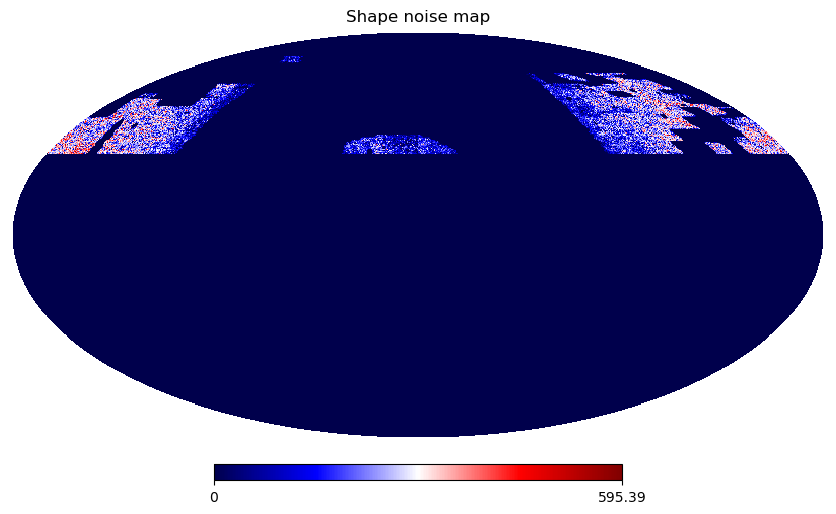

Noise bias: 5.7333702825872006e-05


In [34]:
#Compute the noise bias following Nicola et al.
cat_gal = fits.getdata(output['config']['shape_noise']['path_gal'])

ra_col = output['config']['shape_noise']['ra_col']
dec_col = output['config']['shape_noise']['dec_col']
w_col = output['config']['shape_noise']['w_col']
e1_col = output['config']['shape_noise']['e1_col']
e2_col = output['config']['shape_noise']['e2_col']

theta = (90 - cat_gal[dec_col]) * np.pi / 180
phi = cat_gal[ra_col] * np.pi / 180
pix = hp.ang2pix(nside, theta, phi)

unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)

shape_noise_map = np.zeros(hp.nside2npix(nside))
weights_shape_noise_map = 0.5*cat_gal[w_col]**2*(cat_gal[e1_col]**2 + cat_gal[e2_col]**2)
shape_noise_map[unique_pix] += np.bincount(idx_rep, weights=weights_shape_noise_map)

hp.mollview(shape_noise_map, title='Shape noise map', cmap='seismic')
plt.show()

area_pix = hp.nside2pixarea(nside)
noise_bias = area_pix*np.mean(shape_noise_map)
print(f'Noise bias: {noise_bias}') #Ew doesn't look good

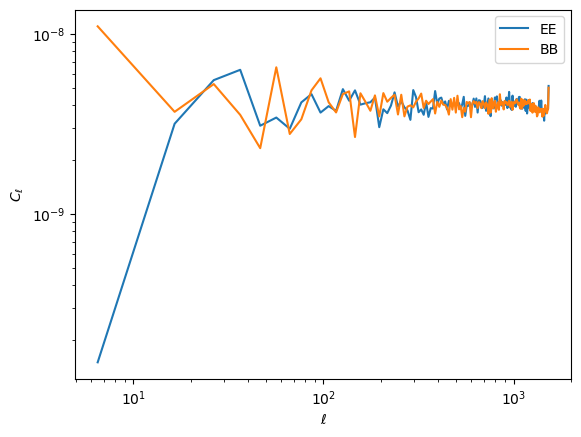

In [31]:
plt.figure()

plt.plot(ell_eff, cl_noise[0], label='EE')
plt.plot(ell_eff, cl_noise[3], label='BB')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

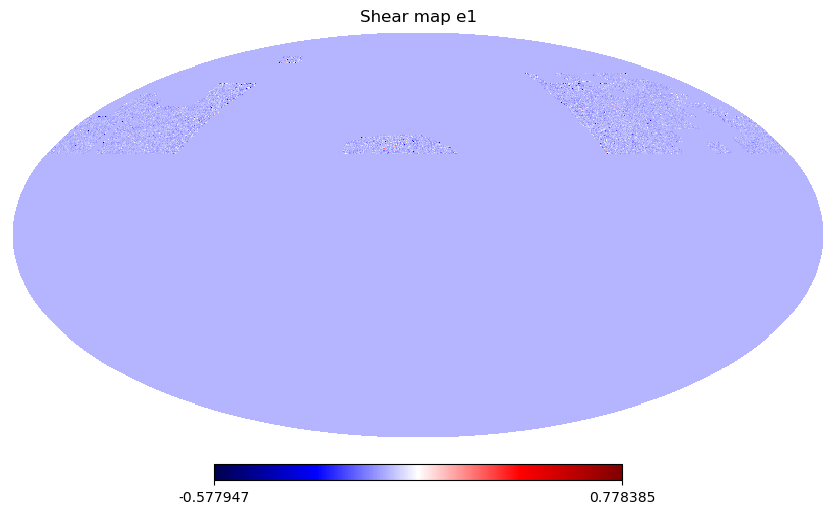

In [41]:
#Check maps with noise and shear signal
shear_map = output['masked_shear_map'] + output['noise_map']

hp.mollview(shear_map.real, title='Shear map e1', cmap='seismic')
plt.show()

In [42]:
kappa_E, kappa_B = kaiser_squire(shear_map)

/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: invalid value encountered in multiply
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: invalid value encountered in multiply


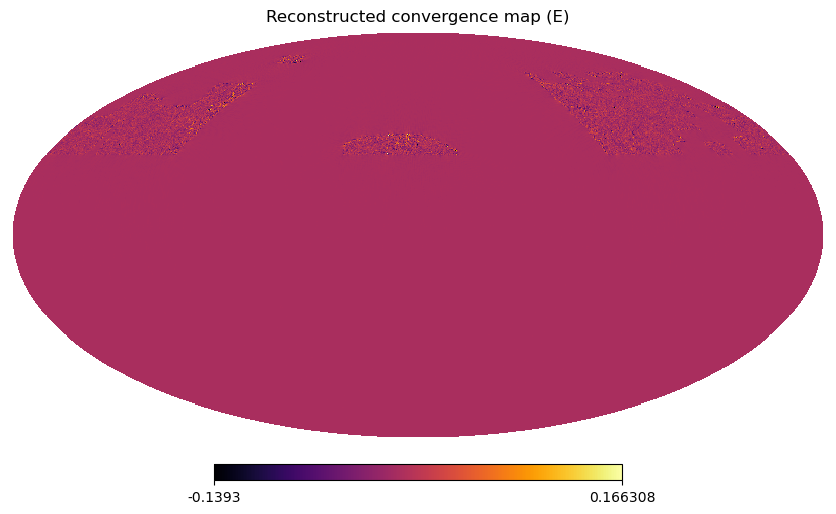

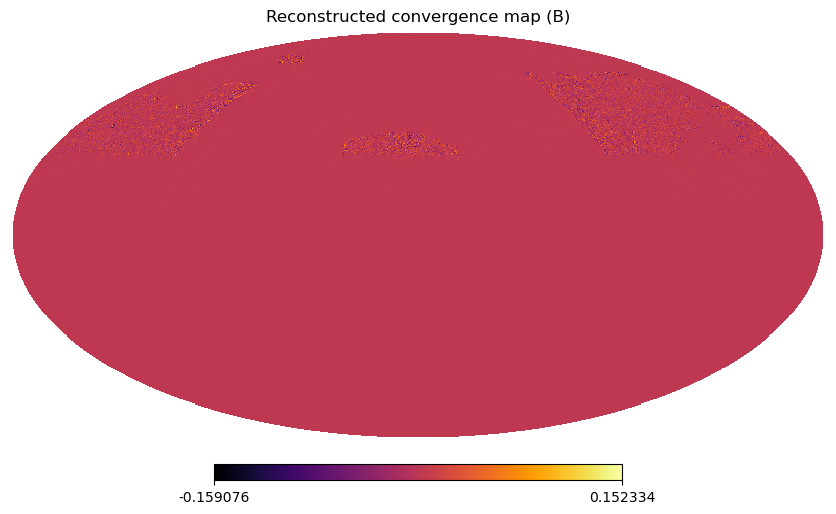

In [43]:
hp.mollview(kappa_E, title='Reconstructed convergence map (E)', cmap='inferno')
plt.show()

hp.mollview(kappa_B, title='Reconstructed convergence map (B)', cmap='inferno')
plt.show()

In [44]:
#Let's check that we got some signal in the pseudo-Cl's

lmin = 8
lmax = 3*nside-1
b_lmax = 3*nside-1
n_ell_bins = 28

b = nmt.NmtBin.from_nside_linear(nside, 10)

ell_eff = b.get_effective_ells()

f_all = nmt.NmtField(mask=(shear_map != 0), maps=[shear_map.real, shear_map.imag])

cl_all = nmt.compute_full_master(f_all, f_all, b)

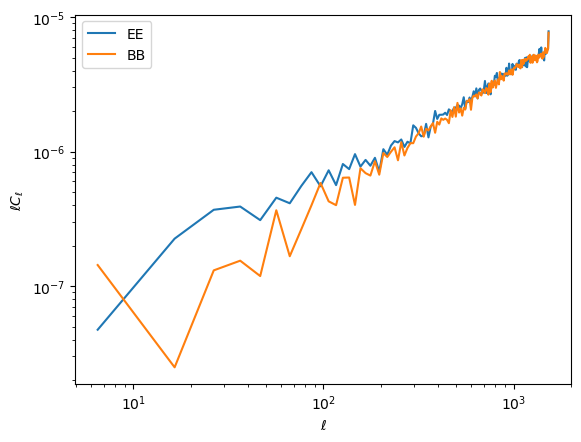

In [46]:
plt.figure()

plt.plot(ell_eff, ell_eff*cl_all[0], label='EE')
plt.plot(ell_eff, ell_eff*cl_all[3], label='BB')

plt.xlabel('$\ell$')
plt.ylabel('$\ell C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

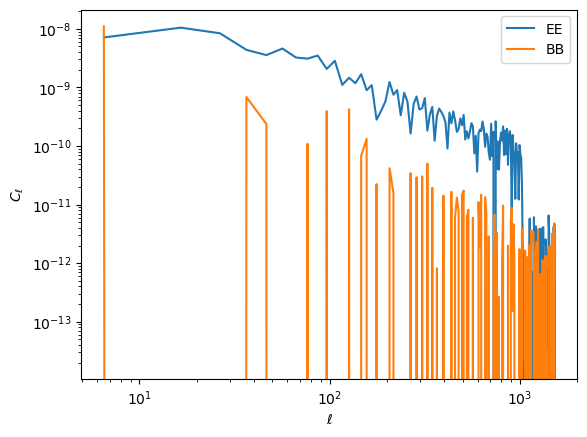

In [47]:
plt.figure()

plt.plot(ell_eff, cl_all[0]-cl_noise[0], label='EE')
plt.plot(ell_eff, cl_all[3]-cl_noise[3], label='BB')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()